# Predicting Stock Prices Using Genetic Programming

## This file was used for exploration purposes only, so thus, it is not extensively documented.

In [1]:
# standard library
import random
import math
import heapq
import copy
import sys
import statistics
import importlib

# 3rd party
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import pandas as pd
import matplotlib.pyplot as plt
from gplearn.genetic import SymbolicRegressor
from statsmodels.stats.proportion import proportions_ztest

# internal imports
import fitness
import individuals
import selection

In [112]:
importlib.reload(fitness)
importlib.reload(individuals)
importlib.reload(selection)

<module 'selection' from '/home/hanz/Documents/msu/cmse202/repo/predicting_stock_prices/genetic/selection.py'>

In [2]:
msft_prices = pd.read_csv('../data/MSFT_reversed.csv')
msft_prices['Date'] = pd.to_datetime(msft_prices['Date'])

In [ ]:
msft_diff = np.diff(msft_prices.Close)

In [43]:
percentage_differences = msft_diff / msft_prices.Close[1:]

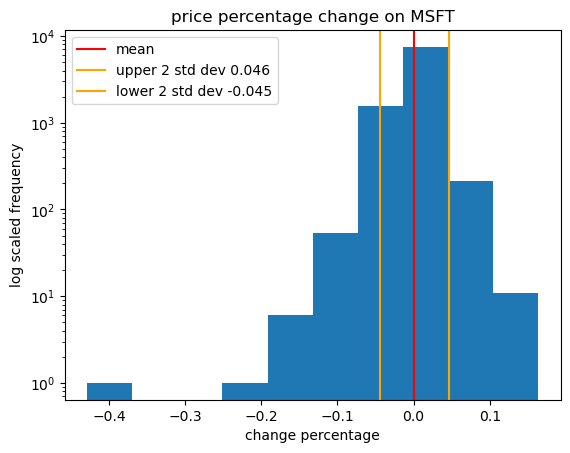

In [148]:
plt.hist(percentage_differences)
# plt.axvline(x=percentage_differences.median(), color='red', label="median")
# plt.axvline(x=np.quantile(percentage_differences, 0.25), color='orange', label="lower quantile")
# plt.axvline(x=np.quantile(percentage_differences, 0.75), color='orange', label="upper quantile")
mean_change = percentage_differences.mean()
plt.axvline(x=mean_change, color='red', label="mean")
two_sigma = percentage_differences.std() * 2
plt.axvline(x=mean_change + two_sigma, color='orange', label=f"upper 2 std dev {mean_change + two_sigma:.3f}")
plt.axvline(x=mean_change - two_sigma, color='orange', label=f"lower 2 std dev {mean_change - two_sigma:.3f}")
plt.semilogy()
plt.title('price percentage change on MSFT')
plt.xlabel('change percentage')
plt.ylabel('log scaled frequency')
plt.legend()

In [132]:
np.mean(percentage_differences)

0.0006343340404794229

## genetic model

In [15]:
msft_slice = msft_prices.iloc[6000:6050].copy()

In [11]:
window_size = 4
predicted_directions = []
percentage_off = []
predictions = []
for y in sliding_window_view(msft_slice.Close.values, window_size + 1):
    y_vals, scale_term = fitness.scale_np(y[:-1])
    x_vals = np.arange(1, window_size + 1) 
    third_of_range = (y_vals.max() - y_vals.min()) / 3
    
    fitness_obj = fitness.Fitness2(y_vals, x_vals)  # withhold last
    #fitness_obj = fitness.Fitness2(y_vals, x_vals)  # withhold last
    population = [individuals.Individual3(fitness_obj.score, param_range=(-third_of_range, third_of_range), sigma=third_of_range, mutation_rate=0.2, crossover_rate=0.5) for _ in range(350)]

    # get num iterations to run
    num_generations = 12
    for _ in range(num_generations):
        population = selection.selection_tournament(population, tournament_size=5)

    # show stats
    solution = min(population)
    #print(solution)
    x = window_size + 2
    prediction = scale_term + fitness.predict(solution, x)
    percent_difference = abs(prediction - y[-1]) / y[-1]
    percentage_off.append(percent_difference)
    #print(f'Guess: {prediction}, Actual: {y[-1]}, Percent: {percent_difference}')
    previous_day = y[-2]
    #print(f'Previous: {previous_day}')
    actual_direction = 'up' if y[-1] - previous_day > 0 else 'down'
    previous_prediction = predictions[-1] if predictions else previous_day
    predicted_direction = 'up' if prediction - previous_prediction > 0 else 'down'
    if actual_direction == predicted_direction:
        #print('Prediction direction correct')
        predicted_directions.append(True)
    else:
        #print('Prediction direction wrong')
        predicted_directions.append(False)
    #print(f'Solution fitness: {solution.score}')
    predictions.append(prediction)
    #print('-' * 70)
    


### doesn't work

window_size = 3
predicted_directions = []
percentage_off = []
predictions = []
for y in sliding_window_view(msft_slice.Close.values, window_size):
    #print(y)
    # previous_day = y[-2]
    # print(f'Previous: {previous_day}')
    actual_direction = 'up' if y[-1] - y[-2] > 0 else 'down'
    #previous_prediction = predictions[-1] if predictions else previous_day
    predicted_direction = 'down' if y[-2] - y[-3] > 0 else 'up'
    if actual_direction == predicted_direction:
        #print('Prediction direction correct')
        predicted_directions.append(True)
    else:
        #print('Prediction direction wrong')
        predicted_directions.append(False)
    #print('-' * 70)

In [12]:
print(len(predicted_directions))
print(pd.Series(predicted_directions).value_counts())

196
False    101
True      95
dtype: int64


<AxesSubplot:>

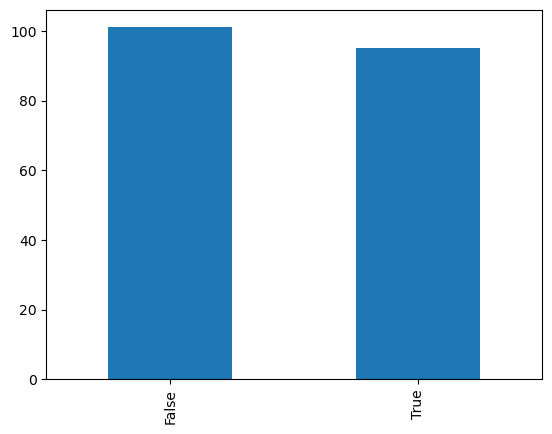

In [13]:
pd.Series(predicted_directions).value_counts().plot.bar()

In [126]:
print(np.median(np.array(percentage_off)))#.median())

0.0226767986668013


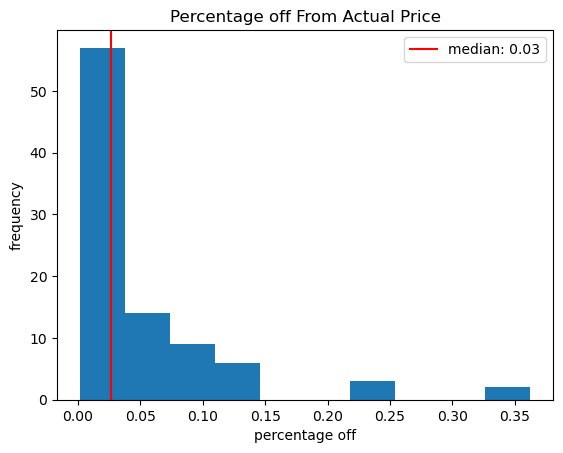

In [75]:
plt.hist(pd.Series(percentage_off))
median_diff = np.median(np.array(percentage_off))
plt.axvline(median_diff, label=f"median: {median_diff:.2f}", color="red")
plt.title('Percentage off From Actual Price')
plt.xlabel('percentage off')
plt.ylabel('frequency')
plt.legend()

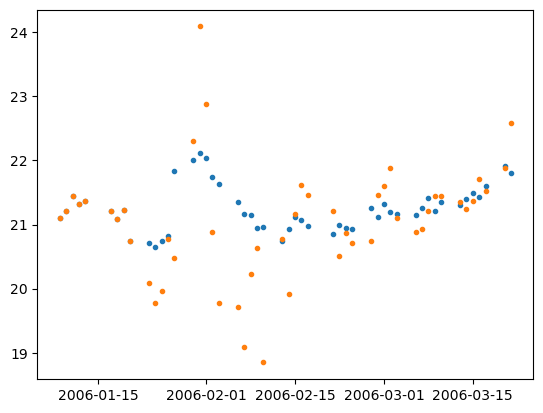

In [187]:
plt.scatter(msft_slice.Date, msft_slice.Close, marker='.')
combined_predictions = np.concatenate((msft_slice.Close.iloc[:9].values, np.array(predictions)))
plt.scatter(msft_slice.Date, combined_predictions, marker='.')

In [22]:
msft_slice.Date = pd.to_datetime(msft_slice.Date)
msft_slice.Close.iloc[:9]

5000    21.1042
5001    21.2143
5002    21.4428
5003    21.3236
5004    21.3653
5005    21.2065
5006    21.0794
5007    21.2313
5008    20.7507
Name: Close, dtype: float64

## GPLearn

In [24]:
# train data
x_train = np.arange(1, 50)
y_train = x_train ** 2 + x_train + 1
x_train = x_train.reshape(-1, 1)
# test data
x_test = np.arange(51, 100)
y_test = x_test ** 2 + x_test + 1
x_test = x_test.reshape(-1, 1)

In [25]:
est_gp = SymbolicRegressor(population_size=2000,
                           generations=20, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0)
est_gp.fit(x_train, y_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    46.41      3.09389e+11        7         0.398542         0.398542      1.44m
   1    34.09           180307       15         0.112458         0.103789     59.02s
   2    17.77      1.01823e+06       15         0.102762         0.189114     40.32s
   3    10.98          2647.86        9                0                0     32.46s


SymbolicRegressor(max_samples=0.9, p_crossover=0.7, p_hoist_mutation=0.05,
                  p_point_mutation=0.1, p_subtree_mutation=0.1,
                  parsimony_coefficient=0.01, population_size=2000,
                  random_state=0, stopping_criteria=0.01, verbose=1)

In [ ]:
window_size = 9
gp_predicted_direction = []
gp_percentage_off = []
gp_predictions = []
for y in sliding_window_view(msft_slice.Close.values, window_size + 1):
    est_gp = SymbolicRegressor(population_size=1500,
                               generations=20, stopping_criteria=0.05,
                               p_crossover=0.7, p_subtree_mutation=0.1,
                               p_hoist_mutation=0.05, p_point_mutation=0.1,
                               max_samples=0.9, verbose=1,
                               parsimony_coefficient=0.003, random_state=0)
    y_train = np.array(y[:-1])
    x_train = np.arange(1, y_train.shape[0] + 1).reshape(-1, 1)
    est_gp.fit(x_train, y_train)
    y_test = np.array(y[-1])
    x_test = np.array(x_train[-1] + 1).reshape(1, -1)
    
    ## stats
    # score
    #score = est_gp.score(x_test, y_test)
    #gp_scores.append(score)
    #print('score:', score)
    # predicted value
    prediction_val = est_gp.predict(x_test)
    gp_predictions.append(prediction_val)
    # difference
    gp_percent_diff = abs(prediction_val - y_test) / y_test
    gp_percentage_off.append(gp_percent_diff)
    print(f'Guess: {prediction_val}, Actual: {y_test}, Percent: {gp_percent_diff}')
    previous_day = y[-2]
    print(f'Previous: {previous_day}')
    did_increase = True if y[-1] - previous_day > 0 else False
    predicted_increase = True if prediction_val[0] - previous_day > 0 else False
    if did_increase == predicted_increase:
        print('Prediction direction correct')
        gp_predicted_direction.append(True)
    else:
        print('Prediction direction wrong')
        gp_predicted_direction.append(False)
    
    print('-' * 70)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    47.53           253782       31          2.30711          3.41989      1.08m
   1    31.59          44.6657       31          1.53651          2.03369     39.79s
   2    33.23           412.22       31          1.00875         0.571706     37.59s
   3    35.79          50.0271       43         0.615495          1.36684     36.76s
   4    32.26          29.0423       25         0.304819         0.454726     34.13s
   5    33.32          42.9911       29          0.23304         0.287409     32.82s
   6    32.28          33.7701       27         0.187727        0.0879418     31.55s
   7    28.25          28.2353       45         0.117544          1.62376     26.46s
   8    23.09          31.3363       25         0.160321         0.383569  

<AxesSubplot:>

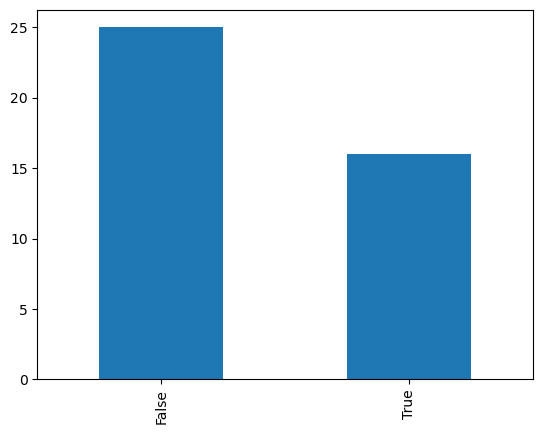

In [177]:
pd.Series(gp_predicted_direction).value_counts().plot.bar()

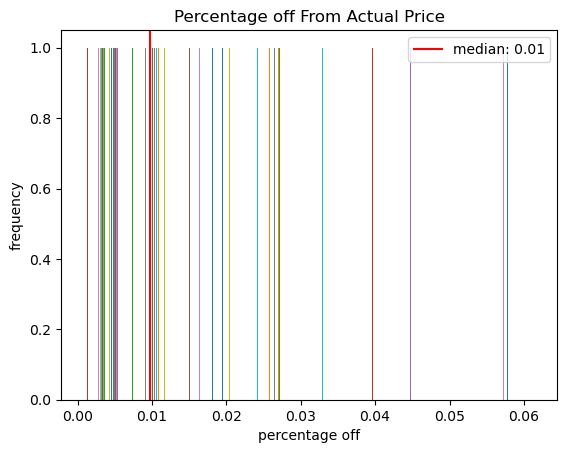

In [178]:
plt.hist(gp_percentage_off)
median_diff = np.median(np.array(gp_percentage_off))
plt.axvline(median_diff, label=f"median: {median_diff:.2f}", color="red")
plt.title('Percentage off From Actual Price')
plt.xlabel('percentage off')
plt.ylabel('frequency')
plt.legend()

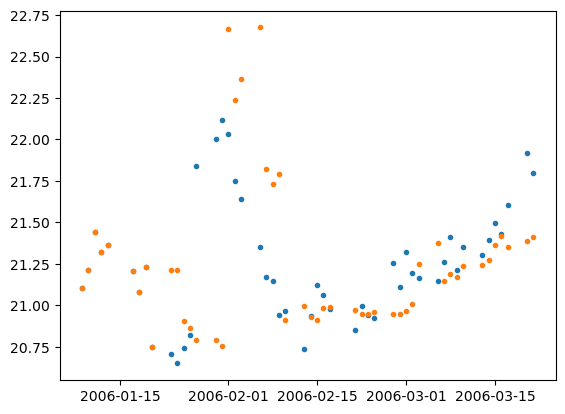

In [179]:
plt.scatter(msft_slice.Date, msft_slice.Close, marker='.')
combined_predictions = np.concatenate((msft_slice.Close.iloc[:9].values, np.array([x[0] for x in gp_predictions])))
plt.scatter(msft_slice.Date, combined_predictions, marker='.')

### gplearn inverse idea

In [182]:
window_size = 9
gp_inverse_predicted_direction = []
gp_inverse_percentage_off = []
gp_inverse_predictions = []
for y in sliding_window_view(msft_slice.Close.values, window_size + 1):
    est_gp = SymbolicRegressor(population_size=250,
                               generations=10, stopping_criteria=0.05,
                               p_crossover=0.7, p_subtree_mutation=0.1,
                               p_hoist_mutation=0.05, p_point_mutation=0.1,
                               max_samples=0.9, verbose=1,
                               parsimony_coefficient=0.003, random_state=0)
    y_train = np.array(y[:-1])
    x_train = np.arange(1, y_train.shape[0] + 1).reshape(-1, 1)
    est_gp.fit(x_train, y_train)
    y_test = np.array(y[-1])
    x_test = np.array(x_train[-1] + 1).reshape(1, -1)
    
    ## stats
    # score
    #score = est_gp.score(x_test, y_test)
    #gp_scores.append(score)
    #print('score:', score)
    # predicted value
    prediction_val = est_gp.predict(x_test)
    gp_inverse_predictions.append(prediction_val)
    # difference
    gp_percent_diff = abs(prediction_val - y_test) / y_test
    gp_inverse_percentage_off.append(gp_percent_diff)
    print(f'Guess: {prediction_val}, Actual: {y_test}, Percent: {gp_percent_diff}')
    previous_day = y[-2]
    print(f'Previous: {previous_day}')
    did_increase = True if y[-1] - previous_day > 0 else False
    predicted_increase = True if prediction_val[0] - previous_day > 0 else False
    if did_increase == predicted_increase:
        print('Prediction direction correct')
        gp_inverse_predicted_direction.append(True)
    else:
        print('Prediction direction wrong')
        gp_inverse_predicted_direction.append(False)
    
    print('-' * 70)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    47.80           103971        7          8.15117          13.3567      5.16s
   1    31.46          54.8117       63          6.11079          2.55802      3.23s
   2    55.33          104.295       61          4.86495          23.9389      3.55s
   3    62.76          84.9191       69          3.04652          27.4505      3.02s
   4    64.18          97.2554       73          3.04295          25.7334      3.13s
   5    75.14          60.0397      109          2.76004          5.35585      2.36s
   6    84.74          347.365      113          2.67471           5.9435      1.78s
   7   104.18          84.2998      159          2.47417           2.6958      1.42s
   8   109.52          126.057      153          2.14095             5.34  

<AxesSubplot:>

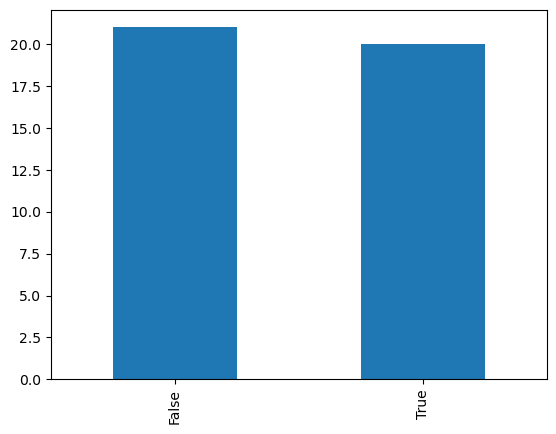

In [183]:
pd.Series(gp_inverse_predicted_direction).value_counts().plot.bar()

In [ ]:
stat1, pval1 = proportions_ztest(count=50, nobs=100, value=25/41)  # https://www.statology.org/one-proportion-z-test-python/
stat2, pval2 = proportions_ztest(count=25, nobs=40, value=0.5, alternative='larger')  # according to https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html